In [1]:
import pandas as pd
import json
import string as str
import numpy as np
import seaborn as sns

from bs4 import BeautifulSoup as bs
import requests
import pprint
import re

sns.set()

# Make charts a bit bolder
#sns.set_context("talk")

%matplotlib inline
%config Completer.use_jedi = False

# Default figure size
sns.set(rc={"figure.figsize": (12,10)})
sns.set_style('whitegrid')

## WebScrapping 

In [5]:
url = "https://www.coingecko.com/"
r = requests.get(url)
soup = bs(r.content, 'html.parser')

results = soup.find_all('a')

#create empty list
tags=[]

#traverse the result and store the hyperlink data into tags list
for tag in results:
    tags.append(str(tag))

baseurl='https://www.coingecko.com'

historytag=[]

for htag in tags:
    if 'd-lg-none font-bold tw-w-12' in htag and 'img class' not in htag:
        mytag=htag.replace('<a class="d-lg-none font-bold tw-w-12" href="', '')
         
        instanceofquotes = mytag.find('"')
        #cleanurl = lenofstring - instanceofquotes 
        mytag_cleaned = (mytag[0:instanceofquotes])
        historytag.append(baseurl+mytag_cleaned+'/historical_data?end_date=2022-05-17&start_date=2016-05-01&page=')
        #historytag.append(baseurl+mytag)

#print(historytag)

res = []

for each in historytag:
    for i in range(1,38):
    
        r1 = requests.get(each.lower()+str(i))
        soup1 = bs(r1.content, 'html.parser')
        tabledata = soup1.find('table', {'class' : 'table table-striped text-sm text-lg-normal'})
        tablebody = tabledata.find('tbody')
        tablerow = tablebody.find_all('tr')
        currecny = each.split("/")[5]
        #print(currecny)
        for each1 in tablerow:

            tableth = each1.find('th')
            #print(tableth.text.strip())
            tabletd = each1.find_all('td')
            #print(tabletd[0].text.strip(),tabletd[1].text.strip(),tabletd[2].text.strip(),tabletd[3].text.strip())
            response = dict()
            response['Date'] = tableth.text.strip()
            response['Currency'] = currecny
            response['MarketCap'] = tabletd[0].text.strip()
            response['Volume'] = tabletd[1].text.strip()
            response['Open'] = tabletd[2].text.strip()
            response['Close'] = tabletd[3].text.strip()
            res.append(response)

TypeError: 'module' object is not callable

## Cleansing the Initially scrapped Data

In [4]:
df = pd.DataFrame(res)
df

""


## Replacing missing values

In [3]:
df = df.replace('N/A',np.nan).replace(np.nan,0)     #Removing all NaNs
df

,Date,Currency,MarketCap,Volume,Open,Close
0,2022-05-17,bitcoin,"$569,801,943,005","$28,418,179,221","$29,924",0
1,2022-05-16,bitcoin,"$596,346,266,889","$22,948,123,704","$31,319","$29,924"
2,2022-05-15,bitcoin,"$573,777,699,744","$25,759,546,764","$30,189","$31,319"
3,2022-05-14,bitcoin,"$558,053,182,541","$71,541,696,924","$29,311","$30,189"
4,2022-05-13,bitcoin,"$555,266,177,877","$61,338,080,284","$29,126","$29,311"
...,...,...,...,...,...,...
112830,2019-06-06,harmony,"$87,097,426","$233,054,307",$0.02844682,$0.02644908
112831,2019-06-05,harmony,"$73,059,966","$173,525,596",$0.02367151,$0.02844682
112832,2019-06-04,harmony,"$65,445,150","$104,052,703",$0.02135917,$0.02367151
112833,2019-06-03,harmony,"$62,776,933","$106,395,567",$0.02050328,$0.02135917


# Converting currency columns to Float

In [4]:
#Removing Special characters from MarketCap, Volume, Open and Close columns and converting to float datatype. 

df['MarketCap'] = df['MarketCap'].str.replace('$','').str.replace(',','')
df['MarketCap'] = df['MarketCap'].astype('float')

df['Close'] = df['Close'].str.replace('$','').str.replace(',','')
df['Close'] = df['Close'].astype('float')

df['Volume'] = df['Volume'].str.replace('$','').str.replace(',','')
df['Volume'] = df['Volume'].astype('float')

df['Open'] = df['Open'].str.replace('$','').str.replace(',','')
df['Open'] = df['Open'].astype('float')

In [5]:
#Removing rows with missing values of Close price

df = df.replace(np.nan,0)
df = df[df.Close != 0]

In [6]:
df.shape

(110904, 6)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 110904 entries, 1 to 112833
Data columns (total 6 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   Date       110904 non-null  datetime64[ns]
 1   Currency   110904 non-null  object        
 2   MarketCap  110904 non-null  float64       
 3   Volume     110904 non-null  float64       
 4   Open       110904 non-null  float64       
 5   Close      110904 non-null  float64       
dtypes: datetime64[ns](1), float64(4), object(1)
memory usage: 5.9+ MB


## Adding New columns

In [8]:
#Sorting the Dates grouped by Currency in ascending order.

df2 = df
df2=df2.groupby(['Currency']).apply(lambda x: x.sort_values(['Date'], ascending=True).drop('Currency', axis=1))
df2.reset_index(level=0, inplace=True)
df = df2

In [9]:
#ADDING COLUMNS WITH ROLLING AVERAGE FOR BUY SELL ANALYSIS:

df['7D_SMA'] = df.groupby('Currency').rolling(7)['Close'].mean().droplevel(level=0)
df['20D_SMA'] = df.groupby('Currency').rolling(20)['Close'].mean().droplevel(level=0)
df['50D_SMA'] = df.groupby('Currency').rolling(50)['Close'].mean().droplevel(level=0)
df['100D_SMA'] = df.groupby('Currency').rolling(100)['Close'].mean().droplevel(level=0)
df['200D_SMA'] = df.groupby('Currency').rolling(200)['Close'].mean().droplevel(level=0)

In [10]:
#Adding columns with percentage change in Close price in a day , a week and a month.

df['24h_%Change'] = df.groupby('Currency', sort=False)['Close'].apply(lambda x: x.pct_change(1)).to_numpy()
df['7D_%Change'] = df.groupby('Currency', sort=False)['Close'].apply(lambda x: x.pct_change(7)).to_numpy() 
df['30D_%Change'] = df.groupby('Currency', sort=False)['Close'].apply(lambda x: x.pct_change(30)).to_numpy()


In [11]:
df = df.fillna(0)
df[df['Currency'] == 'bitcoin'].tail(10)

,Currency,Date,MarketCap,Volume,Open,Close,7D_SMA,20D_SMA,50D_SMA,100D_SMA,200D_SMA,24h_%Change,7D_%Change,30D_%Change
10,bitcoin,2022-05-07,6.870934e+11,3.222329e+10,36116.0,35573.0,37551.142857,38998.95,41658.50,40986.48,46854.085,-0.015035,-0.059438,-0.182512
9,bitcoin,2022-05-08,6.787024e+11,1.913072e+10,35573.0,34070.0,36912.857143,38660.75,41495.86,40954.41,46716.515,-0.042251,-0.115938,-0.194867
8,bitcoin,2022-05-09,6.485143e+11,3.081058e+10,34070.0,30270.0,35728.285714,38099.35,41275.60,40878.58,46557.775,-0.111535,-0.215030,-0.292691
7,bitcoin,2022-05-10,5.761978e+11,5.836993e+10,30270.0,31027.0,34766.714286,37580.85,41074.90,40806.53,46390.320,0.025008,-0.178267,-0.266067
6,bitcoin,2022-05-11,5.906444e+11,5.407136e+10,31027.0,28913.0,33225.857143,37000.05,40805.12,40715.83,46203.695,-0.068134,-0.271695,-0.269947
5,bitcoin,2022-05-12,5.492940e+11,6.598570e+10,28913.0,29126.0,32156.428571,36468.50,40531.60,40621.53,46036.620,0.007367,-0.204468,-0.275581
4,bitcoin,2022-05-13,5.552662e+11,6.133808e+10,29126.0,29311.0,31184.285714,35955.95,40239.10,40526.28,45878.030,0.006352,-0.188421,-0.288654
3,bitcoin,2022-05-14,5.580532e+11,7.154170e+10,29311.0,30189.0,30415.142857,35491.95,39956.24,40458.16,45721.115,0.029955,-0.151351,-0.244501
2,bitcoin,2022-05-15,5.737777e+11,2.575955e+10,30189.0,31319.0,30022.142857,35033.45,39692.40,40400.34,45571.845,0.037431,-0.080746,-0.228349
1,bitcoin,2022-05-16,5.963463e+11,2.294812e+10,31319.0,29924.0,29972.714286,34622.95,39356.58,40282.84,45405.325,-0.044542,-0.011430,-0.260222


In [12]:
# Converting close prices to various currencies

import requests
class RealTimeCurrencyConverter():
    def __init__(self,url):
        self.data= requests.get(url).json()
        self.currencies = self.data['rates']

    def convert(self, from_currency, to_currency, amount): 
        initial_amount = amount 
        #first convert it into USD if it is not in USD.
        # because our base currency is USD
        if from_currency != 'USD' : 
            amount = amount / self.currencies[from_currency] 

        # limiting the precision to 4 decimal places 
        amount = round(amount * self.currencies[to_currency], 4) 
        return amount

url = 'https://api.exchangerate-api.com/v4/latest/USD'
converter = RealTimeCurrencyConverter(url)
df['Close_INR']=(converter.convert('USD','INR',df.Close))
df['Close_EUR']=(converter.convert('USD','EUR',df.Close))
df['Close_JPY']=(converter.convert('USD','JPY',df.Close))
df['Close_GBP']=(converter.convert('USD','GBP',df.Close))
df['Close_CAD']=(converter.convert('USD','CAD',df.Close))
df['Close_DKK']=(converter.convert('USD','DKK',df.Close))

## Saving the structured data in JSON format.

In [13]:
#Saving the cleansed data into JSON format

df.to_json('crypto.json', orient = 'records')

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 110904 entries, 67747 to 92439
Data columns (total 20 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Currency     110904 non-null  object        
 1   Date         110904 non-null  datetime64[ns]
 2   MarketCap    110904 non-null  float64       
 3   Volume       110904 non-null  float64       
 4   Open         110904 non-null  float64       
 5   Close        110904 non-null  float64       
 6   7D_SMA       110904 non-null  float64       
 7   20D_SMA      110904 non-null  float64       
 8   50D_SMA      110904 non-null  float64       
 9   100D_SMA     110904 non-null  float64       
 10  200D_SMA     110904 non-null  float64       
 11  24h_%Change  110904 non-null  float64       
 12  7D_%Change   110904 non-null  float64       
 13  30D_%Change  110904 non-null  float64       
 14  Close_INR    110904 non-null  float64       
 15  Close_EUR    110904 non-null  f

## Importing the cleaned structured dataset

In [15]:
#Importing the cleaned dataset to do analysis

df = pd.read_json('crypto.json')
df.tail(10)

,Currency,Date,MarketCap,Volume,Open,Close,7D_SMA,20D_SMA,50D_SMA,100D_SMA,200D_SMA,24h_%Change,7D_%Change,30D_%Change,Close_INR,Close_EUR,Close_JPY,Close_GBP,Close_CAD,Close_DKK
110894,zilliqa,2022-05-07,1171459734,914804312.0,0.082243,0.076758,0.077688,0.093758,0.102526,0.073594,0.077158,-0.066693,0.055702,-0.426023,5.9580,0.0715,9.7682,0.0609,0.0975,0.5342
110895,zilliqa,2022-05-08,1103777998,570706864.0,0.076758,0.077350,0.078234,0.092237,0.103192,0.073925,0.077074,0.007713,0.051952,-0.361693,6.0039,0.0721,9.8436,0.0614,0.0982,0.5384
110896,zilliqa,2022-05-09,1110075742,427006475.0,0.077350,0.064018,0.077357,0.089857,0.103618,0.074110,0.076927,-0.172359,-0.087478,-0.471122,4.9691,0.0597,8.1469,0.0508,0.0813,0.4456
110897,zilliqa,2022-05-10,929894623,546317437.0,0.064018,0.069557,0.077561,0.087006,0.104144,0.074347,0.076814,0.086523,0.020885,-0.427420,5.3990,0.0648,8.8518,0.0552,0.0883,0.4841
110898,zilliqa,2022-05-11,989959432,858269218.0,0.069557,0.053736,0.071852,0.083903,0.104316,0.074437,0.076602,-0.227454,-0.426480,-0.515879,4.1710,0.0501,6.8384,0.0427,0.0682,0.3740
110899,zilliqa,2022-05-12,763580339,883854012.0,0.053736,0.045961,0.067089,0.080543,0.104254,0.074446,0.076358,-0.144681,-0.420440,-0.574742,3.5675,0.0428,5.8491,0.0365,0.0584,0.3199
110900,zilliqa,2022-05-13,661151412,548777404.0,0.045961,0.050718,0.062585,0.077541,0.104282,0.074496,0.076101,0.103491,-0.383315,-0.549530,3.9367,0.0473,6.4544,0.0403,0.0644,0.3530
110901,zilliqa,2022-05-14,728361169,437485010.0,0.050718,0.052738,0.059154,0.074839,0.104381,0.074580,0.075844,0.039828,-0.312932,-0.543469,4.0935,0.0492,6.7114,0.0419,0.0670,0.3671
110902,zilliqa,2022-05-15,751645249,255828925.0,0.052738,0.055113,0.055977,0.072387,0.103680,0.074682,0.075604,0.045034,-0.287485,-0.506863,4.2779,0.0514,7.0137,0.0438,0.0700,0.3836
110903,zilliqa,2022-05-16,786341292,189233559.0,0.055113,0.050270,0.054013,0.070262,0.102580,0.074682,0.075297,-0.087874,-0.214752,-0.547919,3.9020,0.0469,6.3974,0.0399,0.0638,0.3499


## EDA on the structured dataset

In [16]:
df['Currency'] = df['Currency'].str.upper()
df['Market_Billion'] = df['MarketCap'] / 1000000000
df['Volume_Million'] = df['MarketCap'] / 1000000
df['Volume_Billion'] = df['Volume'] / 1000000000

In [17]:
wide_format = df.groupby(['Date', 'Currency'])['Close'].last().unstack()
wide_format.head(3)

Currency,AAVE,ALGORAND,AMP,APECOIN,ARWEAVE,AVALANCHE,AXIE-INFINITY,BASIC-ATTENTION-TOKEN,BINANCE-USD,BITCOIN,...,TRON,TRUE-USD,UNISWAP,USD-COIN,VECHAIN,WAVES,WRAPPED-BITCOIN,XRP,ZCASH,ZILLIQA
Date,,,,,,,,,,,,,,,,,,,,,
2016-05-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,444.49,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.006713,NaN,NaN
2016-05-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,450.30,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.006559,NaN,NaN
2016-05-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,447.12,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.006314,NaN,NaN


## Top 10 Currencies by Market Cap in USD

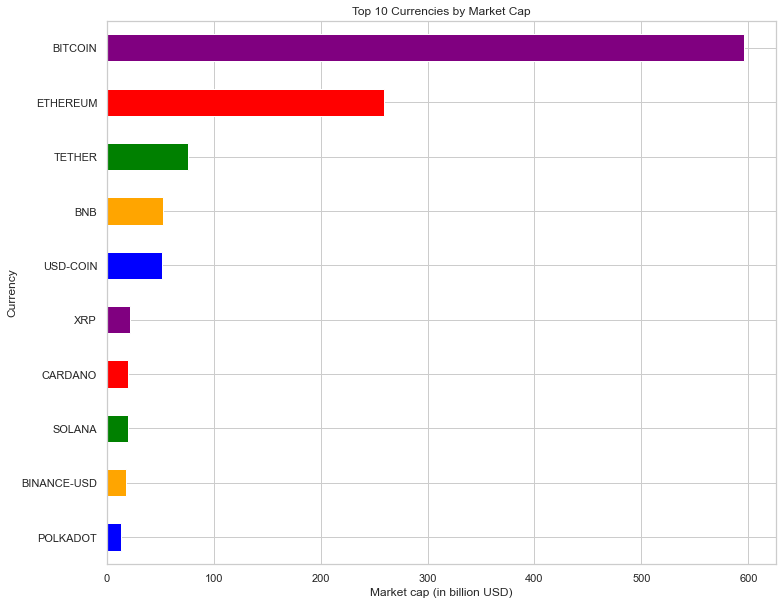

In [18]:
import matplotlib.pyplot as plt

col = ['blue','orange','green','red','purple']

ax = df.groupby(['Currency'])['Market_Billion'].last().sort_values(ascending=False).head(10).sort_values().plot(kind='barh', color=col);
ax.set_xlabel("Market cap (in billion USD)");
plt.title("Top 10 Currencies by Market Cap");


## Top 10 Currencies by Volume (in Billion USD)

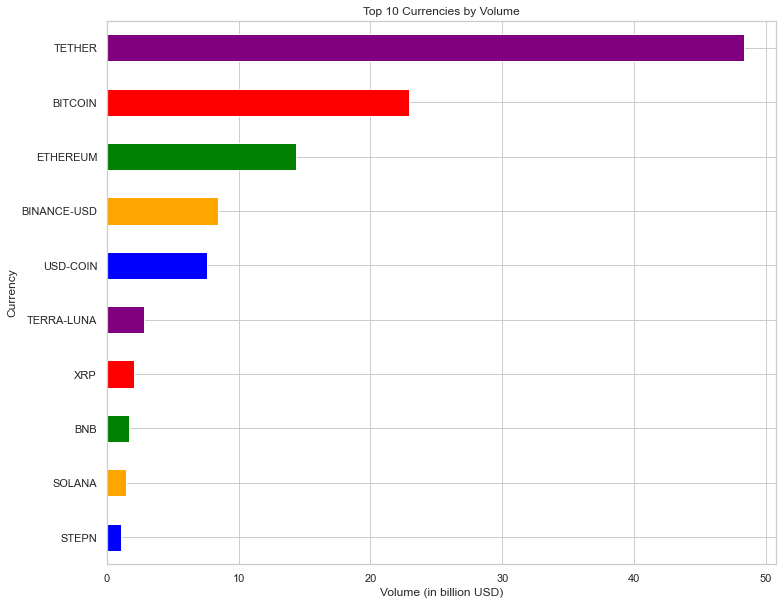

In [17]:

bx = df.groupby(['Currency'])['Volume_Billion'].last().sort_values(ascending=False).head(10).sort_values()
bx = bx.plot(kind='barh' , color=col);
bx.set_xlabel("Volume (in billion USD)");
plt.title("Top 10 Currencies by Volume");


## Top 10 Currencies by Volume(in Million) in USD

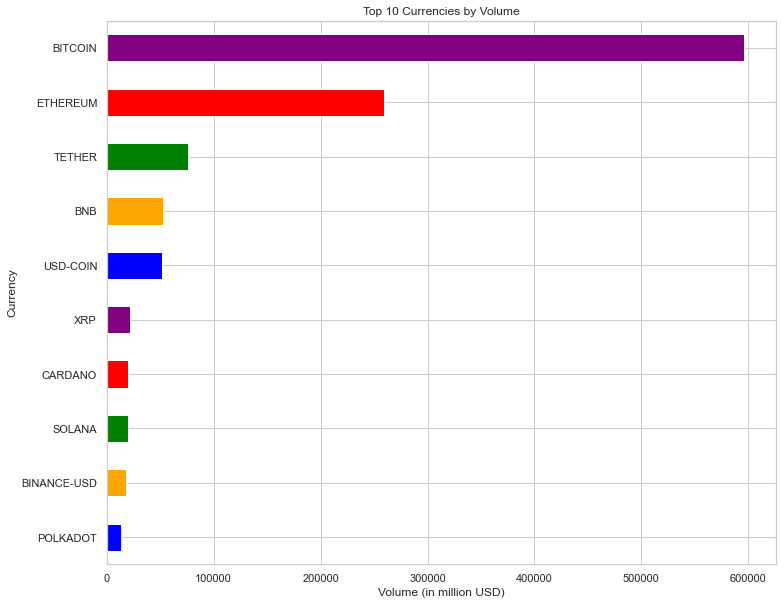

In [18]:
cx = df.groupby(['Currency'])['Volume_Million'].last().sort_values(ascending=False).head(10).sort_values().plot(kind='barh', color=col);
cx.set_xlabel("Volume (in million USD)");
plt.title("Top 10 Currencies by Volume");

## Analysis of Top 10 Currencies from 2017 to 2022

In [19]:
#Defining the top 10 currencies
top_10_currency_names = df.groupby(['Currency'])['MarketCap'].last().sort_values(ascending=False).head(10).index
data_top_10_currencies = df[df['Currency'].isin(top_10_currency_names)]
#data_top_10_currencies.head(5)

#Defining the top 5 currencies
top_5_currency_names = df.groupby(['Currency'])['MarketCap'].last().sort_values(ascending=False).head(5).index
data_top_5_currencies = df[df['Currency'].isin(top_5_currency_names)]
#data_top_5_currencies.head(5)

## Close Price Trend for Top 10 currencies in INR

Text(0.5, 1.0, 'Price per unit of currency')

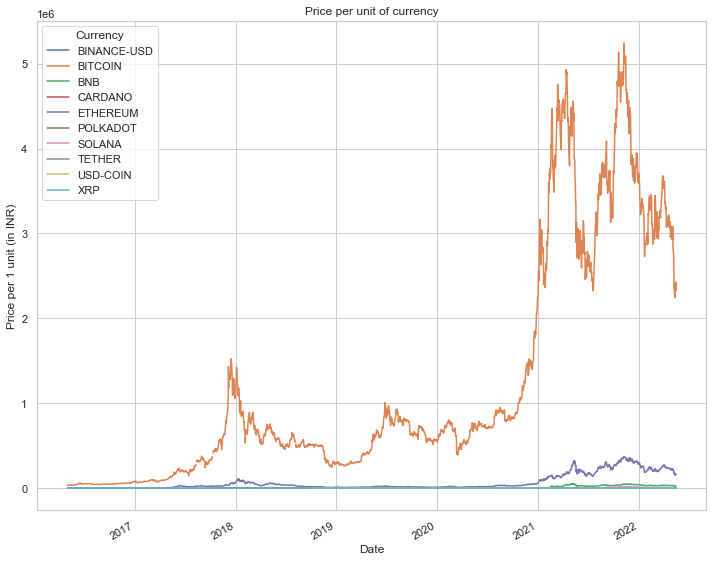

In [20]:
dx = data_top_10_currencies.groupby(['Date', 'Currency'])['Close_INR'].mean().unstack().plot()
dx.set_ylabel("Price per 1 unit (in INR)")
plt.title("Price per unit of currency")

## Trend from 2017 to 2022 for Top 10 currencies

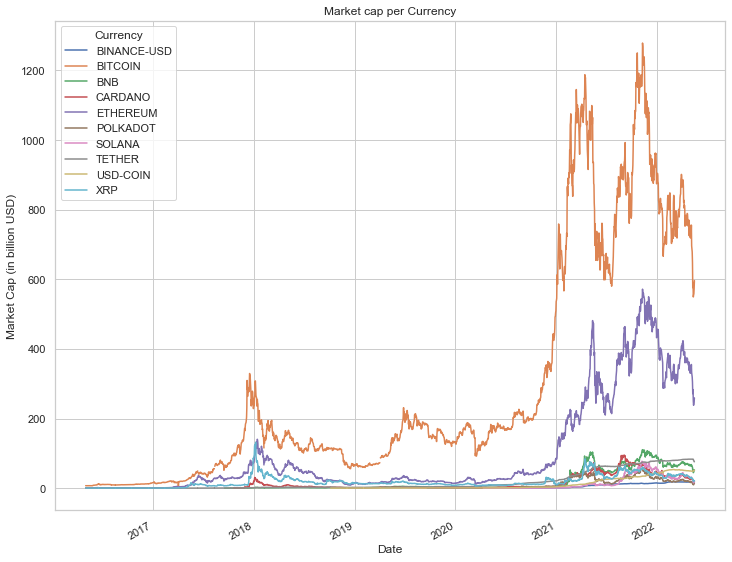

In [21]:
fx = data_top_10_currencies.groupby(['Date', 'Currency'])['Market_Billion'].mean().unstack().plot()
fx.set_ylabel("Market Cap (in billion USD)");
plt.title("Market cap per Currency");

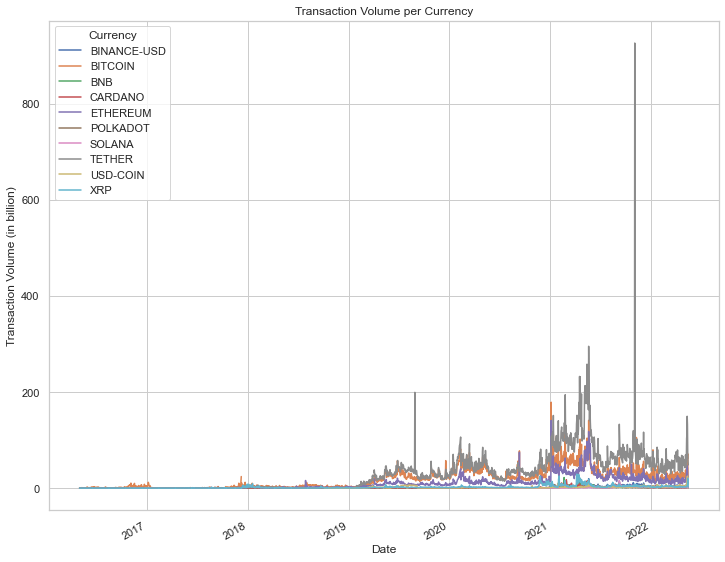

In [22]:
gx = data_top_10_currencies.groupby(['Date', 'Currency'])['Volume_Billion'].mean().unstack().plot()
gx.set_ylabel("Transaction Volume (in billion)");
plt.title("Transaction Volume per Currency");

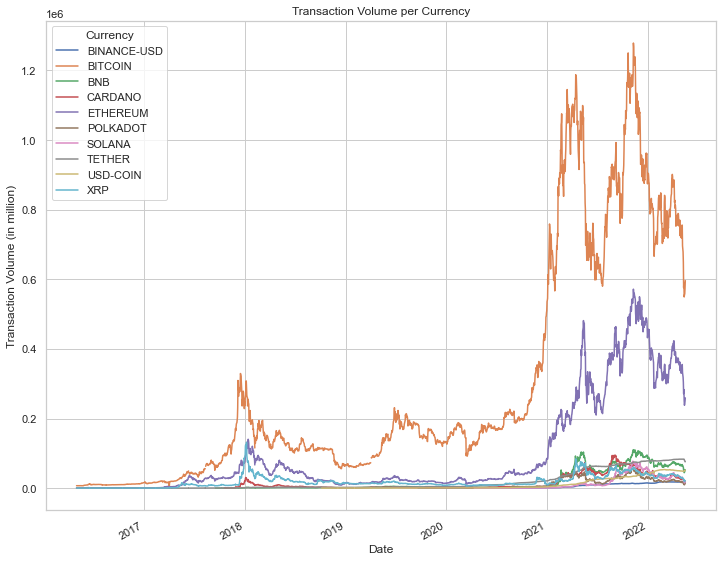

In [23]:
hx = data_top_10_currencies.groupby(['Date', 'Currency'])['Volume_Million'].mean().unstack().plot()
hx.set_ylabel("Transaction Volume (in million)");
plt.title("Transaction Volume per Currency");

## Trend charts from 2020 for Top 5 currencies

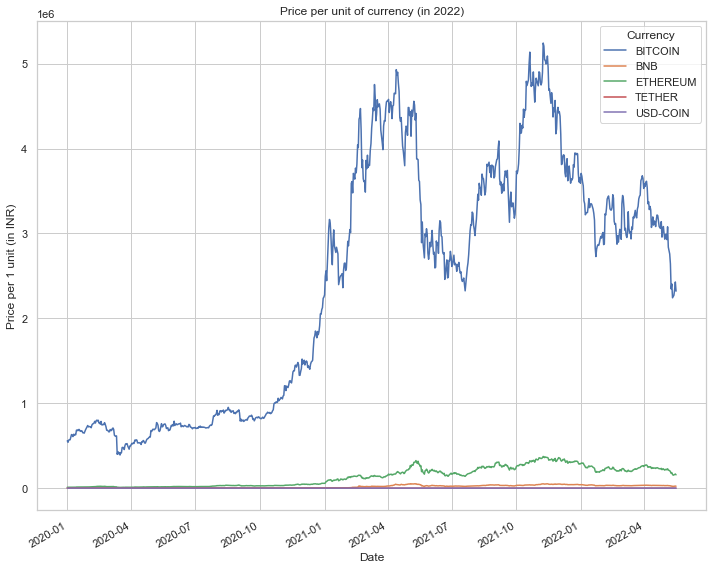

In [24]:
#Close_price trends for Top 5 crypto-currencies

ix = data_top_5_currencies[data_top_5_currencies.Date.dt.year >= 2020].groupby(['Date', 'Currency'])['Close_INR'].mean().unstack().plot();
ix.set_ylabel("Price per 1 unit (in INR)");
plt.title("Price per unit of currency (in 2022)");

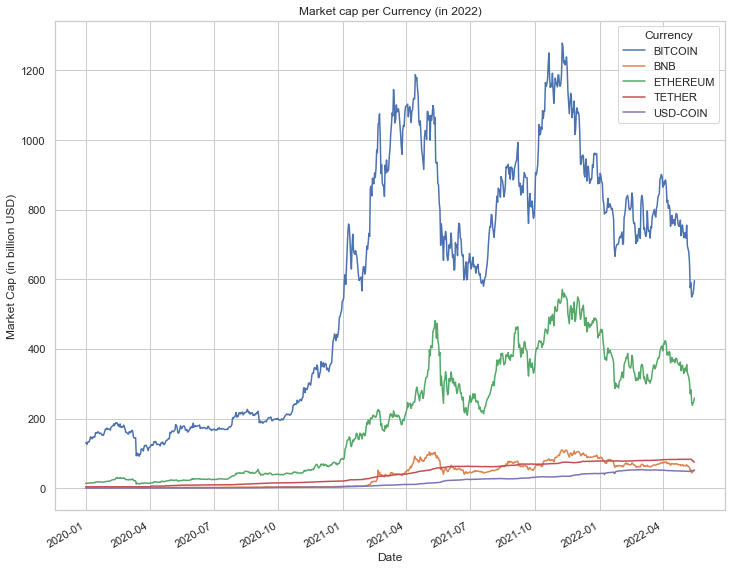

In [25]:
ix = data_top_5_currencies[data_top_5_currencies.Date.dt.year >= 2020].groupby(['Date', 'Currency'])['Market_Billion'].mean().unstack().plot();
ix.set_ylabel("Market Cap (in billion USD)");
plt.title("Market cap per Currency (in 2022)");

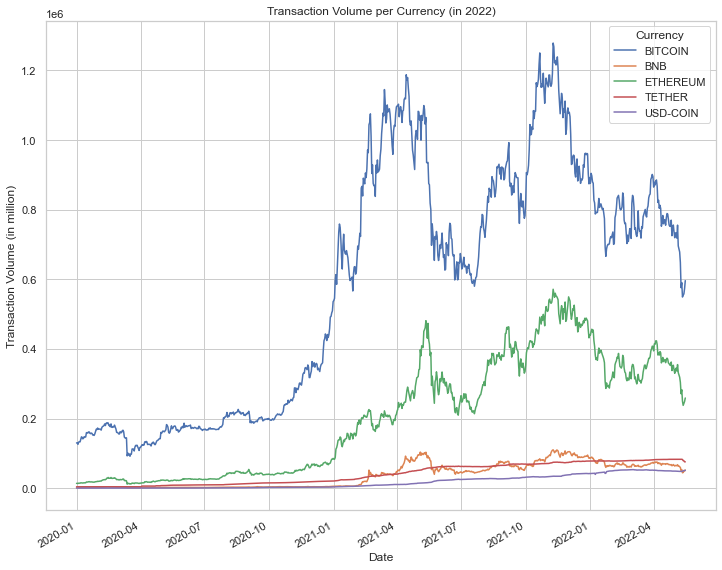

In [26]:
ix = data_top_5_currencies[data_top_5_currencies.Date.dt.year >= 2020].groupby(['Date', 'Currency'])['Volume_Million'].mean().unstack().plot();
ix.set_ylabel("Transaction Volume (in million)");
plt.title("Transaction Volume per Currency (in 2022)");

## Correlation for Top 5 Currencies based on MarketCap

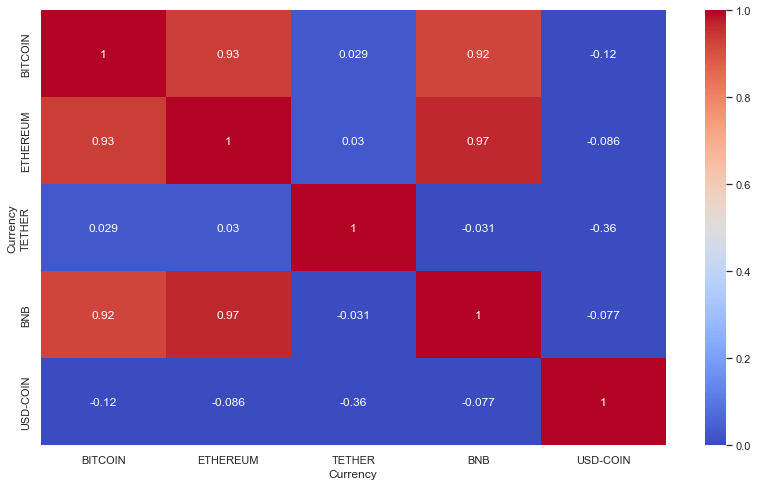

In [27]:
plt.figure(figsize=(14,8))
sns.heatmap(wide_format[top_5_currency_names].corr(),vmin=0, vmax=1, cmap='coolwarm', annot=True);

In [28]:
is_bitcoin = df['Currency'] == 'BITCOIN'
is_ethereum = df['Currency'] == 'ETHEREUM'
is_ripple  = df['Currency'] == 'TETHER'

In [29]:
# Pull out a part of dataset that only has the most interesting currencies
data_top_currencies = df[is_bitcoin | is_ethereum | is_ripple]

Text(0, 0.5, 'Price per 1 unit (in USD)')

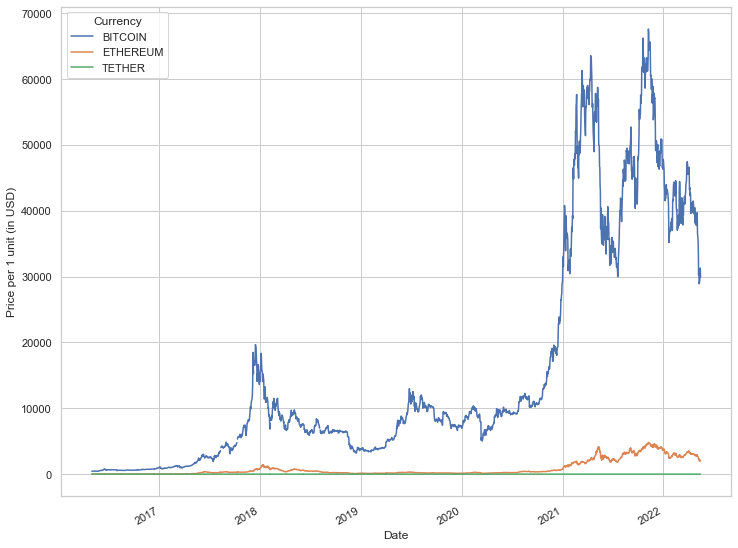

In [30]:
ax = data_top_currencies.groupby(['Date', 'Currency'])['Close'].mean().unstack().plot()
ax.set_ylabel("Price per 1 unit (in USD)")

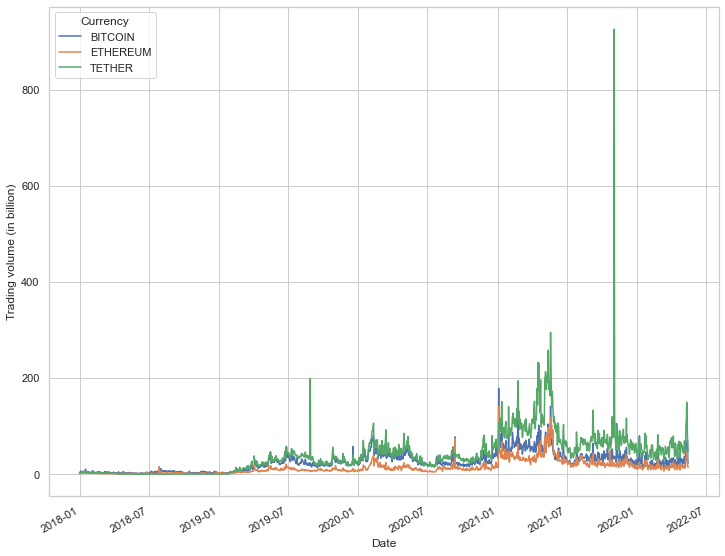

In [31]:
ax = data_top_currencies[data_top_currencies.Date.dt.year >= 2018].groupby(['Date', 'Currency'])['Volume_Billion'].mean().unstack().plot()
ax.set_ylabel("Trading volume (in billion)");


## Buy or Sell Trends using Moving Averages for Bitcoin, Ethereum and TETHER

In [32]:
df_btc = df[df['Currency'] == 'BITCOIN']

df_btc = df_btc[df_btc['Date'] > '2022-01-01']

df_btc = df_btc.replace(0, np.nan)
df_btc = df_btc.dropna()
df_btc = df_btc.set_index('Date')
df_btc = df_btc[['Close','20D_SMA','50D_SMA']]

In [33]:
Buy = []
Sell = []

for i in range(len(df_btc)):
    
    if (df_btc['20D_SMA'].iloc[i] > df_btc['50D_SMA'].iloc[i]) and (df_btc['20D_SMA'].iloc[i-1] < df_btc['50D_SMA'].iloc[i-1]):
        Buy.append(i)
    elif (df_btc['20D_SMA'].iloc[i] < df_btc['50D_SMA'].iloc[i]) and (df_btc['20D_SMA'].iloc[i-1] > df_btc['50D_SMA'].iloc[i-1]):
        Sell.append(i)
        

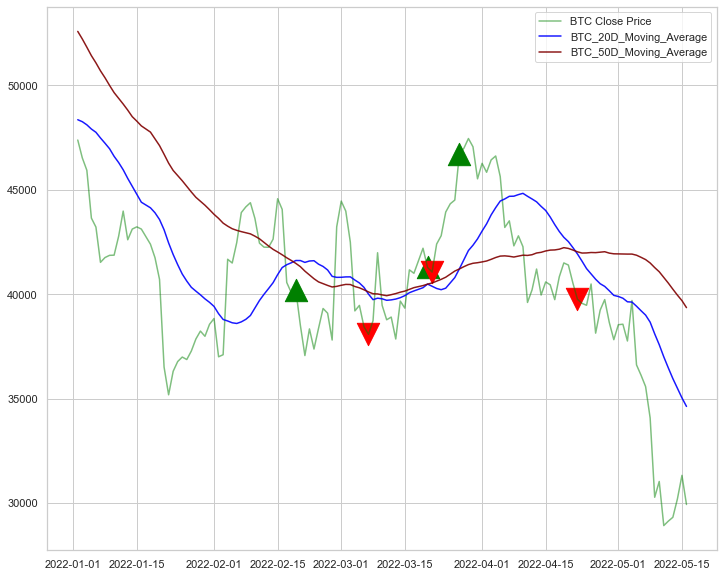

In [34]:
plt.plot(df_btc['Close'], label = 'BTC Close Price', c = 'green', alpha =0.5)
plt.plot(df_btc['20D_SMA'], label = 'BTC_20D_Moving_Average', c = 'blue', alpha =0.9)
plt.plot(df_btc['50D_SMA'], label = 'BTC_50D_Moving_Average', c = 'maroon', alpha =0.9)
plt.scatter(df_btc.iloc[Buy].index, df_btc.iloc[Buy]['Close'], marker = '^',color = 'green', s=500)
plt.scatter(df_btc.iloc[Sell].index, df_btc.iloc[Sell]['Close'], marker = 'v',color = 'red', s=500)
plt.legend()
plt.show()

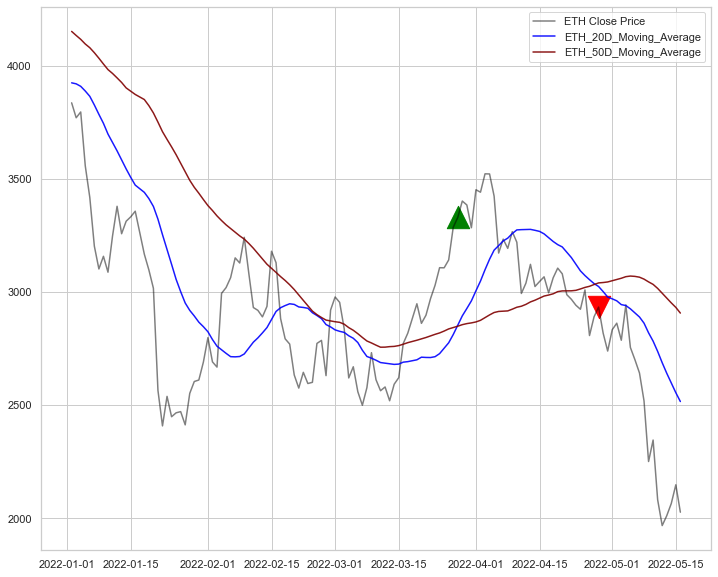

In [35]:
#Filtering out ethereum records

df_eth = df[df['Currency'] == 'ETHEREUM']

df_eth = df_eth[df_eth['Date'] > '2022-01-01']

df_eth = df_eth.replace(0, np.nan)
df_eth = df_eth.dropna()
df_eth = df_eth.set_index('Date')
     
df_eth = df_eth[['Close','20D_SMA','50D_SMA']]

#Selecting the buying and selling poinnts
Buy = []
Sell = []

for i in range(len(df_eth)):
    
    if (df_eth['20D_SMA'].iloc[i] > df_eth['50D_SMA'].iloc[i]) and (df_eth['20D_SMA'].iloc[i-1] < df_eth['50D_SMA'].iloc[i-1]):
        Buy.append(i)
    elif (df_eth['20D_SMA'].iloc[i] < df_eth['50D_SMA'].iloc[i]) and (df_eth['20D_SMA'].iloc[i-1] > df_eth['50D_SMA'].iloc[i-1]):
        Sell.append(i)

        
#Plotting the moving averages

plt.plot(df_eth['Close'], label = 'ETH Close Price', c = 'black', alpha =0.5)
plt.plot(df_eth['20D_SMA'], label = 'ETH_20D_Moving_Average', c = 'blue', alpha =0.9)
plt.plot(df_eth['50D_SMA'], label = 'ETH_50D_Moving_Average', c = 'maroon', alpha =0.9)
plt.scatter(df_eth.iloc[Buy].index, df_eth.iloc[Buy]['Close'], marker = '^',color = 'green', s=500)
plt.scatter(df_eth.iloc[Sell].index, df_eth.iloc[Sell]['Close'], marker = 'v',color = 'red', s=500)
plt.legend()
plt.show()                       

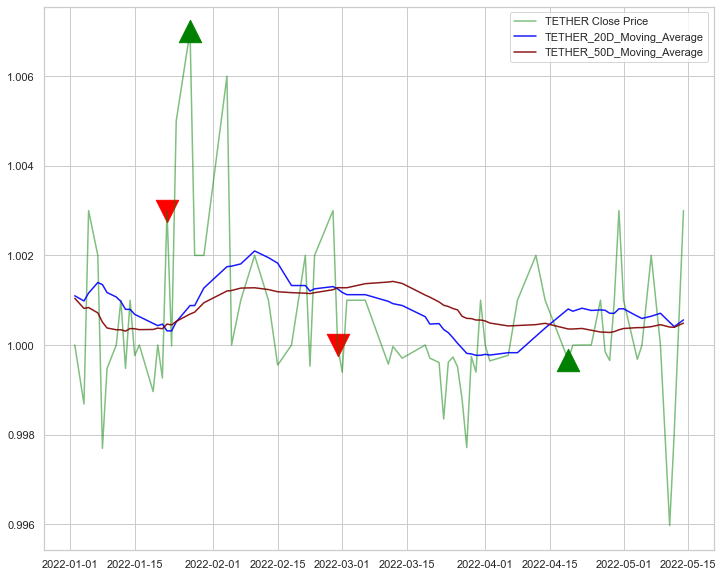

In [36]:
#Filtering out bnb records

df_bnb = df[df['Currency'] == 'TETHER']
df_bnb = df_bnb[df_bnb['Date'] > '2022-01-01']

df_bnb = df_bnb.replace(0, np.nan)
df_bnb = df_bnb.dropna()
df_bnb = df_bnb.set_index('Date')
df_bnb = df_bnb[['Close','20D_SMA','50D_SMA']]

#Selecting the buying and selling poinnts
Buy = []
Sell = []

for i in range(len(df_bnb)):
    
    if (df_bnb['20D_SMA'].iloc[i] > df_bnb['50D_SMA'].iloc[i]) and (df_bnb['20D_SMA'].iloc[i-1] < df_bnb['50D_SMA'].iloc[i-1]):
        Buy.append(i)
    elif (df_bnb['20D_SMA'].iloc[i] < df_bnb['50D_SMA'].iloc[i]) and (df_bnb['20D_SMA'].iloc[i-1] > df_bnb['50D_SMA'].iloc[i-1]):
        Sell.append(i)

        
#Plotting the moving averages

plt.plot(df_bnb['Close'], label = 'TETHER Close Price', c = 'green', alpha =0.5)
plt.plot(df_bnb['20D_SMA'], label = 'TETHER_20D_Moving_Average', c = 'blue', alpha =0.9)
plt.plot(df_bnb['50D_SMA'], label = 'TETHER_50D_Moving_Average', c = 'maroon', alpha =0.9)
plt.scatter(df_bnb.iloc[Buy].index, df_bnb.iloc[Buy]['Close'], marker = '^',color = 'green', s=500)
plt.scatter(df_bnb.iloc[Sell].index, df_bnb.iloc[Sell]['Close'], marker = 'v',color = 'red', s=500)
plt.legend()
plt.show()      


## Predicting Bitcoin and Ethereum close prices on 2022-05-01 

In [19]:
# Defining CAGR function which will help in calculating the CAGR

def CAGR(start, end, time):
    Growth_Rate = (end/start)**(1/time)-1
    return Growth_Rate

#Saving bitcoin data into one dataframe
df_bitcoin = df[df['Currency'] == 'BITCOIN']


#Saving ethereum data into one dataframe
df_ethereum = df[df['Currency'] == 'ETHEREUM']



#Extracting Close price data for Start date

start_btc = df_bitcoin['Close'][df_bitcoin['Date'] == '2020-04-30'].iloc[0]
start_eth = df_ethereum['Close'][df_ethereum['Date'] == '2020-04-30'].iloc[0]
print('Price of Ethereum on 2020-04-30=',start_eth,'$')
print('Price of Bitcoin on 2020-04-30=',start_btc,'$')

print('--------------------------------------------------------------------------')

#Extracting Close price data for End date
end_btc = df_bitcoin['Close'][df_bitcoin['Date'] == '2022-05-01'].iloc[0]
end_eth = df_ethereum['Close'][df_ethereum['Date'] == '2022-05-01'].iloc[0]
print('Price of Ethereum on 2022-05-01=',end_eth,'$')
print('Price of Bitcoin on 2022-05-01=',end_btc,'$')

print('--------------------------------------------------------------------------')
#Calculating CAGR for ethereum in the last 2 years
eth_CAGR = CAGR(start_eth, end_eth, 2)
btc_CAGR = CAGR(start_btc, end_btc, 2)

print('Etherium grows with a CAGR of',round(eth_CAGR,2),'%')
print('Bitcoin grows with a CAGR of',round(btc_CAGR,2),'%')

# Defining forcast function 
def forecast(end, CAGRr, years):
    forc = end + (1+CAGRr)**years
    return forc
print('--------------------------------------------------------------------------')
# forcasting ethereum price in next 6 years based on CAGR calculated
years = 6
print('Forecast for ethereum in 6 years time', round(forecast(end_eth, eth_CAGR, years)))
print('Forecast for bitcoin in 6 years time', round(forecast(end_btc, btc_CAGR, years)))

Price of Ethereum on 2020-04-30= 205.56 $
Price of Bitcoin on 2020-04-30= 8610.64 $
--------------------------------------------------------------------------
Price of Ethereum on 2022-05-01= 2832.51 $
Price of Bitcoin on 2022-05-01= 38538.0 $
--------------------------------------------------------------------------
Etherium grows with a CAGR of 2.71 %
Bitcoin grows with a CAGR of 1.12 %
--------------------------------------------------------------------------
Forecast for ethereum in 6 years time 5449
Forecast for bitcoin in 6 years time 38628
